In [2]:
import torch
from transformer import GPTModel
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,        #A
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,             #B
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (trf_block): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (query_w): Linear(in_features=768, out_features=768, bias=False)
        (key_w): Linear(in_features=768, out_features=768, bias=False)
        (value_w): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (proj_out): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (query_w): Linear(in_feature

In [3]:
import tiktoken
from transformer import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [4]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                       [40, 1107, 588]])    # "I really like"]
# Matching these inputs, the `targets` contain the token IDs we aim for the model to produce:
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                        [107, 588, 11311]]) # " really like chocolate"]
with torch.no_grad():                  #A
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape)
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)


torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [5]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [6]:
# 提取target对应的probability
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([3.9108e-05, 5.6776e-05, 4.7559e-06])


In [7]:
#防止概率的数值下溢，所以对目标的概率取对数
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -10.1492,  -9.7764, -12.2561])
tensor(-10.5722)
tensor(10.5722)


In [8]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [9]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Logits shape:", logits_flat.shape)
print("Targets shape:", targets_flat.shape)

Logits shape: torch.Size([6, 50257])
Targets shape: torch.Size([6])


In [10]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.5722)


In [11]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [12]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [13]:
from dataset import create_dataloader_v1
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [14]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [15]:
import torch.nn.functional as F
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)

    loss = F.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)                                    
    else:
        num_batches = min(num_batches, len(data_loader))               
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()                                     
        else:
            break
    return total_loss / num_batches                                   


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model.to(device)
with torch.no_grad():                                                 
    train_loss = calc_loss_loader(train_loader, model, device)        
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.98110580444336


In [17]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []                        #A
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):                                                 #B
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()                                                   #C
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()                                                         #D
            optimizer.step()                                                        #E
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:                                        #F
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(                                                  #G
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen


#A 初始化用于记录损失和已处理 token 数量的列表
#B 开始主训练循环
#C 重置上一批次的损失梯度
#D 计算损失梯度
#E 使用损失梯度更新模型权重
#F 可选的评估步骤
#G 每个 epoch 结束后打印示例文本
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()                #A
    with torch.no_grad():       #B
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

#A 评估阶段禁用 dropout，以确保结果稳定、可复现
#B 禁用梯度跟踪，减少计算开销

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " ")) # Compact print format
    model.train()

In [18]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)      #A
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=1,
    start_context="Every effort moves you", tokenizer=tokenizer
)


Ep 1 (Step 000000): Train loss 10.060, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.156, Val loss 8.340
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.551, Val loss 7.052
Ep 2 (Step 000015): Train loss 5.924, Val loss 6.600
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.835, Val loss 6.479
Ep 3 (Step 000025): Train loss 5.434, Val loss 6.411
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Ep 4 (Step 000030): Train loss 4.804, Val loss 6.366
Ep 4 (Step 000035): Train loss 5.201, Val loss 6.384
Every effort moves you a a, and a a, and a-- the picture. Gisburn, and a was a--and, and a. G. I had a of the a, and a. I had the of the a of the of the of
Ep 5 (Step 000040): Train loss 4.394, Val loss 6.246
Every effort moves you, one of the of the of the picture to the

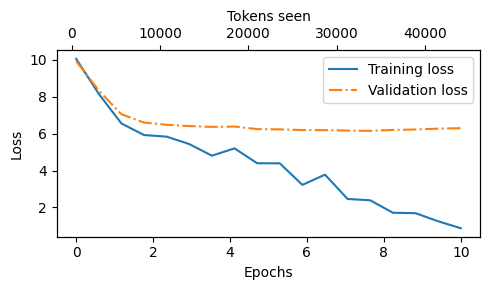

In [19]:
import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny() #A
    ax2.plot(tokens_seen, train_losses, alpha=0) #B
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [20]:
model.to("cpu")
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [21]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [22]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [23]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


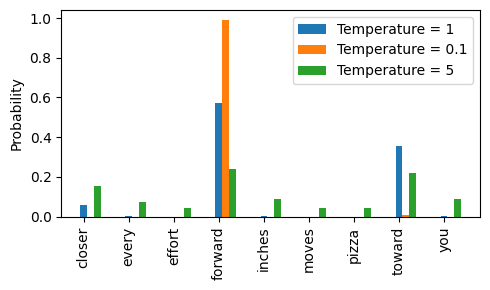

In [24]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)
temperatures = [1, 0.1, 5]             
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()


In [25]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [26]:
#将topk之外的logits都设为-inf
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],   
    input=torch.tensor(float('-inf')),              
    other=next_token_logits                         
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [27]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [28]:
def generate(model, idx, max_new_tokens, context_size, temperature=1.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx)
        logits = logits[:, -1, :]
        if top_k:
            topk_logits, _ = torch.topk(logits, top_k)
            min_val = topk_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        
        if temperature > 0.0:
            logits = logits / temperature
            probas = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probas, num_samples=1)
        else:
            next_token = torch.argmax(logits, dim=-1, keepdim=True)

        if next_token == eos_id:
            break
            
        idx = torch.cat((idx, next_token), dim=1)
    return idx


print(device)
model.to(device)
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))



cuda
Output text:
 Every effort moves you as terr what one of the pale yellow to put that with a curious.


In [29]:
torch.save(model.state_dict(), "model.pth")

In [30]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (trf_block): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (query_w): Linear(in_features=768, out_features=768, bias=False)
        (key_w): Linear(in_features=768, out_features=768, bias=False)
        (value_w): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (proj_out): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (query_w): Linear(in_feature

In [31]:
# save optimizer
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict()
    },
    "model_and_optimizer.pth"
)

In [32]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optim = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optim.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (trf_block): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (query_w): Linear(in_features=768, out_features=768, bias=False)
        (key_w): Linear(in_features=768, out_features=768, bias=False)
        (value_w): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (proj_out): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (query_w): Linear(in_feature

In [33]:
from importlib.metadata import version
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.18.0
tqdm version: 4.67.1


In [34]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [36]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [ ]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
# Suppose we are interested in loading the smallest model, "gpt2-small (124M)". We can use the corresponding settings from the model_configs table able to update our full-length GPT_CONFIG_124M we defined and used earlier throughout the chapter as follows:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024})